In [48]:
#Importing Libraries
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from torch import nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch.nn import functional as F
from matplotlib import pyplot as plt
import random

In [49]:
#Selecting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [50]:
torch.cuda.empty_cache()

In [51]:
class SparseAutoencoder(nn.Module):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding= 1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        encoded_data = self.encoder(x)
        
        decoded_data = self.decoder(encoded_data)
        return x

In [52]:
model=SparseAutoencoder().to(device)

rho=0.005
beta=0.001

learning_rate=0.001
num_epochs=3
batch_size=128
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

In [53]:
train_dataset = datasets.MNIST(root='./dataset', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='./dataset', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [54]:
model_children=list(model.children())

In [55]:
def KL_divergence(rho, rho_hat):

    rho_hat = torch.mean(torch.sigmoid(rho_hat), dim=1)
    rho = torch.tensor(rho/len(rho_hat)).to(device)
    
    return torch.sum(rho * torch.log(rho/rho_hat) + (1-rho) * torch.log((1-rho)/(1-rho_hat)))

In [56]:
def sparse_loss(rho, images):
    values = images
    loss = 0
    for i in range(len(model_children)):
        values = model_children[i](values)
        loss += KL_divergence(rho, values)
    
    return loss

Epoch: 1/3  Loss: 104.2640


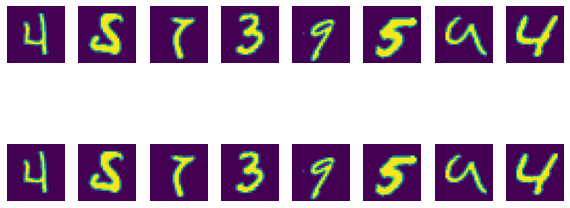

Epoch: 2/3  Loss: 104.2560


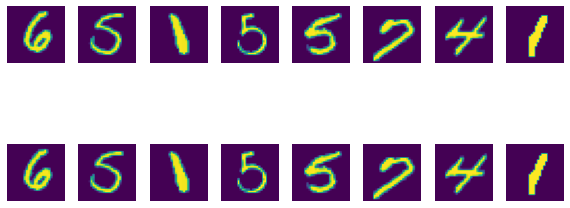

Epoch: 3/3  Loss: 104.2543


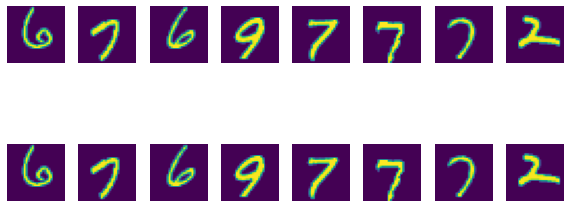

In [57]:
#Training the model
losses=[]

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device=device)

        output = model(images)

        loss = criterion(output, images) + beta*sparse_loss(rho, images)

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        loss = loss.detach().cpu().numpy()
        losses.append(loss.item())

    print('Epoch: {}/{} '.format(epoch+1, num_epochs),
              'Loss: {:.4f}'.format(loss))
    

    #To convert cuda tensor to numpy array
    data= images.detach().cpu().numpy()
    output = output.detach().cpu().numpy()

    #Plotting the data
    plt.figure(figsize = (10,20))

    for i in range(8):
        plt.subplot(16,8,i+1)
        plt.imshow(data[i].reshape(28,28))
        plt.axis('off')

        plt.subplot(16,8,i + 17)
        plt.imshow(output[i].reshape(28,28))
        plt.axis('off')

    plt.show()

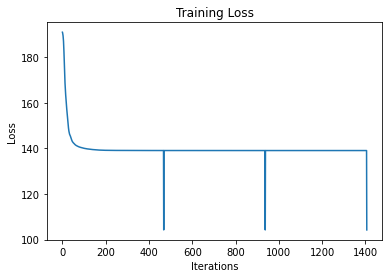

In [58]:
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(losses)
plt.show()

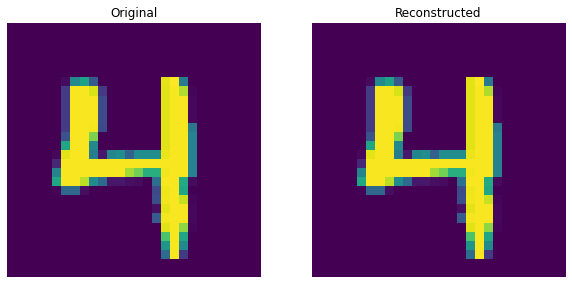

In [59]:
index= random.randint(0, len(test_dataset))

with torch.no_grad():
    data= test_dataset[index][0].view(1,1,28,28)
    data= data.to(device)
    output = model(data)
    
    data=data.detach().cpu().numpy()

    output = output.detach().cpu().numpy()

    plt.figure(figsize = (10,25))
    plt.subplot(1,2,1)
    plt.title('Original')
    plt.imshow(data[0].reshape(28,28))
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title('Reconstructed')
    plt.imshow(output[0].reshape(28,28))
    plt.axis('off')
    plt.show()